In [1]:
import paper_dataloaders
import paper_models

from seqdata.core import *
from seqdata.models.core import *
from seqdata.learner import *
from seqdata.dataloaders import *
from seqdata.dualrnn import *
from seqdata.hpopt import *
from fastai.basics import *
from fastai.callback.all import *
from seqdata.quaternions import *
from pathlib import Path
from ray import tune
import pickle

from paper_dataloaders import *
from paper_models import *

# Extract Models

In [2]:
import ray
from ray import tune
from fastai.basics import *
import pandas as pd
%matplotlib widget
ray.init()

2024-06-27 10:34:45,110	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.10.8
Ray version:,2.9.3


In [3]:
experiment_path = Path.home() / 'ray_results/FranSys_P4A_models_no_hpopt'
unopt_experiment = tune.ExperimentAnalysis(experiment_path,default_metric='_rmse',default_mode='min')
df_unopt = unopt_experiment.dataframe()
df_unopt = df_unopt[df_unopt.training_iteration ==100]
df_unopt['trial'] = df_unopt.trial_id.apply(lambda t_id: first(unopt_experiment.trials, lambda y: y.trial_id == t_id))
df_unopt.head(3)

,train_loss,valid_loss,_rmse,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,trial_id,date,...,config/dl,config/model,config/size,config/pct_start,config/n_epoch,config/create_lrn,config/dls,config/fit_method,logdir,trial
0,0.023856,11.403892,17.646397,1710595203,checkpoint_000099,True,False,100,aa97a_00019,2024-03-16_14-20-03,...,Robot,nargru,large,0.2,100,ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000002e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000003e1f505),aa97a_00019,learner_optimize_aa97a_00019
1,0.179305,12.242573,19.048798,1710598614,checkpoint_000099,True,False,100,aa97a_00031,2024-03-16_15-16-54,...,Robot,argru_init,small,0.2,100,ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000002e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000003e1f505),aa97a_00031,learner_optimize_aa97a_00031
2,0.012489,12.551797,18.590942,1710603093,checkpoint_000099,True,False,100,aa97a_00025,2024-03-16_16-31-34,...,Robot,argru_washout,large,0.2,100,ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000002e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000003e1f505),aa97a_00025,learner_optimize_aa97a_00025


In [4]:
experiment_path = Path.home() / 'ray_results/FranSys_P4A_models_hpopt'
experiments = get_files(experiment_path,'.json').filter(lambda x: 'experiment_state' in x.name)
experiment_list = [tune.ExperimentAnalysis(e,default_metric='_rmse',default_mode='min') for e in experiments]
df_opt = pd.concat([e.dataframe() for e in experiment_list],ignore_index=True)
trials = list(flatten([exp.trials for exp in experiment_list]))
df_opt = df_opt[df_opt.training_iteration ==100]
df_opt['trial'] = df_opt.trial_id.apply(lambda t_id: first(trials, lambda y: y.trial_id == t_id))
df_opt.head(3)

,train_loss,valid_loss,_rmse,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,trial_id,date,...,config/has_hidden_p,config/weight_p,config/has_weight_p,config/opt_beta,config/lr,config/create_lrn,config/dls,config/fit_method,logdir,trial
0,0.119336,0.264901,0.405482,1710596060,checkpoint_000099,True,False,100,e7c59_00015,2024-03-16_13-34-20,...,False,0.476649,False,7750.642800,0.005287,ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000002e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000003e1f505),e7c59_00015,learner_optimize_e7c59_00015
1,2.310244,10.032192,16.494186,1710590763,checkpoint_000099,True,False,100,e7c59_00028,2024-03-16_12-06-03,...,False,0.240450,True,118.410665,0.009256,ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000002e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000003e1f505),e7c59_00028,learner_optimize_e7c59_00028
2,0.036019,0.018209,0.033178,1710590902,checkpoint_000099,True,False,100,e7c59_00038,2024-03-16_12-08-22,...,False,0.346234,False,4763.427092,0.002657,ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000002e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000003e1f505),e7c59_00038,learner_optimize_e7c59_00038


# Evaluate Speed

## inference Speed Data

In [ ]:
dls = create_dls_robot_forward_prediction()
n_u, n_y, n_x, init_sz, _ = get_dls_parameters(create_dls_robot_forward_prediction)

In [ ]:
df = pd.DataFrame({
    'model':['nargru','argru_init','argru_washout']*3,
    'size':['small','small','small','medium','medium','medium','large','large','large'],
})
df['model_constructor'] = df.apply(lambda row:get_model_constr(row['model'],row['size']),axis=1)
df = df.iloc[::-1].copy()
df

,model,size,model_constructor
0,nargru,small,<function model_narprog_small at 0x7fdbfd69cd30>
1,argru_init,small,<function model_ar_rnn_init_small at 0x7fdbfd69dc60>
2,argru_washout,small,<function model_ar_rnn_washout_small at 0x7fdbfd69d7e0>
3,nargru,medium,<function model_narprog_medium at 0x7fdbfd69cdc0>
4,argru_init,medium,<function model_ar_rnn_init_medium at 0x7fdbfd69dcf0>
5,argru_washout,medium,<function model_ar_rnn_washout_medium at 0x7fdbfd69db40>
6,nargru,large,<function model_narprog_large at 0x7fdbfd69ce50>
7,argru_init,large,<function model_ar_rnn_init_large at 0x7fdbfd69dd80>
8,argru_washout,large,<function model_ar_rnn_washout_large at 0x7fdbfd69dbd0>


In [ ]:
import timeit
@ray.remote(num_gpus=1)
def measure_performance_inference(row,n_loop_max = 5*(2**13)):
    model_constructor = row['model_constructor']
    model = model_constructor(n_u,n_x,n_y,1).cuda()

    if row['model'] == 'argru_init':
        model.rnn_prognosis.init_normalize(dls.one_batch())
    elif row['model'] == 'argru_washout':
        model.rnn_model.init_normalize(dls.one_batch())
    
    xb = torch.zeros(1,1000,n_u+n_y,device='cuda:0')
    model.eval()
    model(xb);
    size = row['size']
    speed = {}
    for seq_len in 2**np.arange(2,13):
        xb = torch.zeros(1,seq_len,n_u+n_y,device='cuda:0')
        # n_loop = int( n_loop_max // np.log2(seq_len))
        n_loop = int( n_loop_max // seq_len)*4
        speed[seq_len] = timeit.timeit(lambda :model(xb),number=n_loop)/n_loop*1000
    # Call the model constructor with the size argument
    return speed
# measure_performance_inference(df.iloc[0])

In [ ]:
results = ray.get(list(df.apply(measure_performance_inference.remote, axis=1)))

(measure_performance_inference pid=2562871) Library "haste_pytorch" not found
(measure_performance_inference pid=2564933) Library "haste_pytorch" not found [repeated 4x across cluster]
(measure_performance_inference pid=2574335) Library "haste_pytorch" not found
(measure_performance_inference pid=2575423) Library "haste_pytorch" not found
(measure_performance_inference pid=2575791) Library "haste_pytorch" not found
(measure_performance_inference pid=2579055) Library "haste_pytorch" not found


In [ ]:
df['inference_speed'] = results

## Training Speed Data

In [ ]:
@ray.remote(num_gpus=1)
def measure_performance_training(row):
    model_constructor = row['model_constructor']
    n_iter = 20 if row['model'] == 'nargru' else 1
    speed = {}
    for pred_sz in 2**np.arange(2,11+1):
        max_batches = 300
        n_iter_b = int(n_iter*(11/np.log2(pred_sz))) if row['model'] == 'nargru' else n_iter
        dls = create_dls_pelican_prediction(pred_sz=pred_sz,max_batches_training=max_batches,max_batches_valid=0)
        n_batches = len(dls.train)
        n_u, n_y, n_x, init_sz, _ = get_dls_parameters(create_dls_pelican_prediction)
        model = model_constructor(n_u,n_x,n_y,1)
        if row['model'] == 'argru_init':
            model.rnn_prognosis.init_normalize(dls.one_batch())
        elif row['model'] == 'argru_washout':
            model.rnn_model.init_normalize(dls.one_batch())
        lrn = Learner(dls,model,loss_func=SkipNLoss(mae,init_sz))
        with (lrn.no_bar(),lrn.no_logging()):
            speed[pred_sz] = (timeit.timeit(lambda: lrn.fit(1) ,number=n_iter_b)/n_iter_b)
    return speed
results = ray.get(list(df.apply(measure_performance_training.remote, axis=1)))
df['training_speed'] = results
#df.to_pickle('speed_df.p')

(pid=1450948) Library "haste_pytorch" not found
(pid=1631243) Library "haste_pytorch" not found [repeated 4x across cluster]
(pid=1713647) Library "haste_pytorch" not found
(pid=1820661) Library "haste_pytorch" not found
(pid=2005163) Library "haste_pytorch" not found
(pid=2038259) Library "haste_pytorch" not found


# Plots

In [5]:
df = pd.read_pickle('speed_df.p')

In [6]:
# Define your custom colors
#custom_palette = {
#    'NAR-RNN': '#1f77b4',  # Blue
#    'AR-RNN': '#ff7f0e',  # Orange
#    'AR-RNN-Init': '#ffbb78'   # Lighter Orange
#}
custom_palette = {
    'NAR-RNN': 'darkcyan',#'cornflowerblue',  # mediumpurple
    'AR-RNN': 'dimgray',  # Orange
    'AR-RNN-Init': 'darkgray'   # Lighter Orange
}
plt.rcParams.update({
    "text.usetex": True,
    'font.size': 13,
    'font.family': "Times New Roman"
})

/tmp/ipykernel_9554/528963611.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3,h_pad=1.)


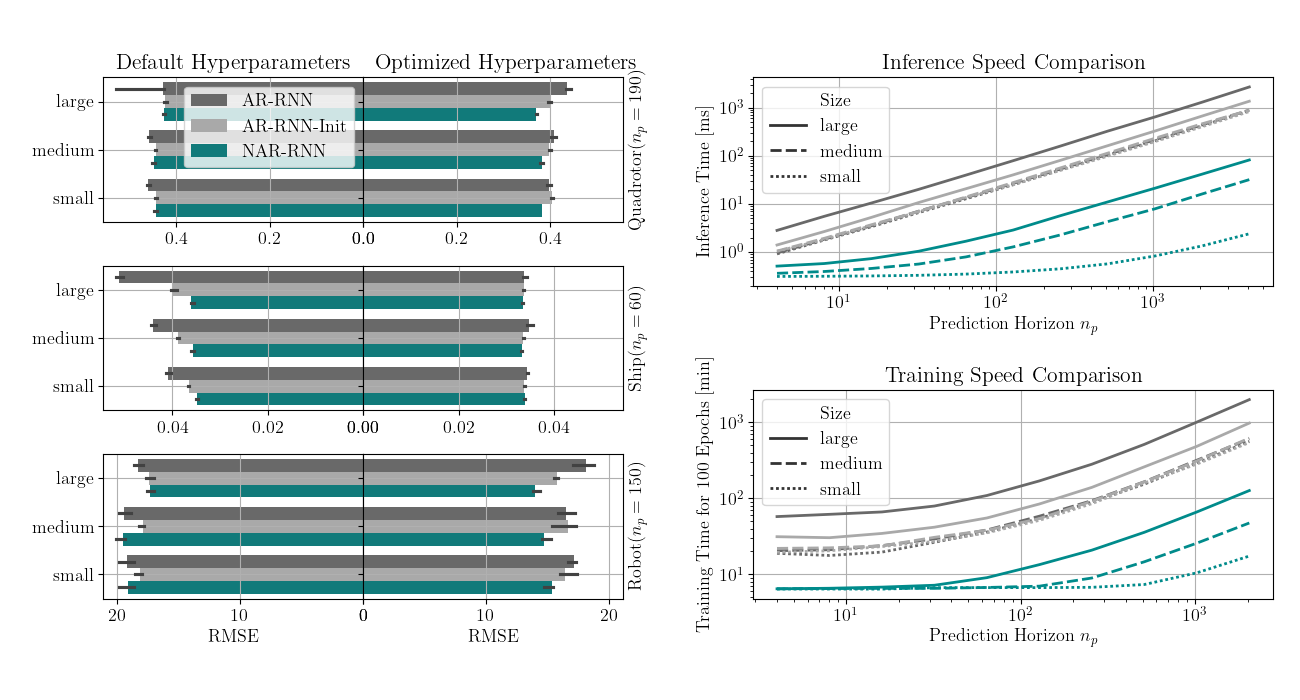

In [43]:
import seaborn as sns
fig = plt.figure(figsize=(13, 7))

# Define the grid layout for the main figure
# 1 row, 2 columns: the left column for the 2x3 grid, the right column for the stacked subfigures
main_grid = fig.add_gridspec(1, 2, width_ratios=[1, 1], height_ratios=[1],wspace=0,hspace=0)


# Create a nested subfigure for the left column
left_subfig = fig.add_subfigure(main_grid[0, 0])
(axs) = left_subfig.subplots(ncols=2,nrows=3, gridspec_kw={'wspace': 0.00})

df_unopt=df_unopt.sort_values(['config/model','config/size']).replace('nargru','NAR-RNN').replace('argru_init','AR-RNN-Init').replace('argru_washout','AR-RNN')
df_opt=df_opt.sort_values(['config/model','config/size']).replace('nargru','NAR-RNN').replace('argru_init','AR-RNN-Init').replace('argru_washout','AR-RNN')

#No optimized hyperparameters
ax = axs[0,0]
sns.barplot(ax=ax,data=df_unopt[df_unopt['config/dl']=='Quadrotor'],y='config/size',x='_rmse',hue='config/model',estimator=np.median,palette=custom_palette)
ax.set_xlim(left=0)
ax.set_xlabel("")
ax.set_ylabel('Quadrotor')
ax.yaxis.set_label_position("right")
ax.invert_xaxis()  # reverse the direction
ax.legend(loc='upper right')
ax.set_title('     Default Hyperparameters')
ax.grid()

ax = axs[1,0]
sns.barplot(ax=ax,data=df_unopt[df_unopt['config/dl']=='Ship'],y='config/size',x='_rmse',hue='config/model',estimator=np.median,palette=custom_palette)
ax.set_xlim(left=0)
ax.set_xlabel("")
ax.set_ylabel('Ship')
ax.yaxis.set_label_position("right")
ax.invert_xaxis()  # reverse the direction
ax.legend_.remove()
ax.grid()

ax = axs[2,0]
sns.barplot(ax=ax,data=df_unopt[df_unopt['config/dl']=='Robot'],y='config/size',x='_rmse',hue='config/model',estimator=np.median,palette=custom_palette)
ax.set_xlim(left=0)
# ax.set_ylabel("")
ax.set_ylabel('Robot')
ax.yaxis.set_label_position("right")
ax.set_xlabel("RMSE")
ax.invert_xaxis()  # reverse the direction
ax.legend_.remove()
ax.grid()

#with optimized parameters
ax = axs[0,1]
sns.barplot(ax=ax,data=df_opt[df_opt['config/dl']=='Quadrotor'],y='config/size',x='_rmse',hue='config/model',estimator=np.median,palette=custom_palette)
ax.set_xlim(np.flip(axs[0,0].get_xlim()))
ax.set_xlabel("")
ax.set_ylabel('Quadrotor$(n_p=190)$')
ax.yaxis.set_label_position("right")
ax.set_yticklabels([])
ax.legend_.remove()
ax.grid()
ax.set_title('Optimized Hyperparameters',loc='left', x=0.05)

ax = axs[1,1]
sns.barplot(ax=ax,data=df_opt[df_opt['config/dl']=='Ship'],y='config/size',x='_rmse',hue='config/model',estimator=np.median,palette=custom_palette)
ax.set_xlim(np.flip(axs[1,0].get_xlim()))
ax.set_xlabel("")
ax.set_ylabel('Ship$(n_p=60)$')
ax.yaxis.set_label_position("right")
ax.set_yticklabels([])
ax.legend_.remove()
ax.grid()

ax = axs[2,1]
sns.barplot(ax=ax,data=df_opt[df_opt['config/dl']=='Robot'],y='config/size',x='_rmse',hue='config/model',estimator=np.median,palette=custom_palette)
ax.set_xlim(np.flip(axs[2,0].get_xlim()))
# ax.set_ylabel("")
ax.set_ylabel('Robot$(n_p=150)$')
ax.yaxis.set_label_position("right")
ax.set_yticklabels([])
ax.set_xlabel("RMSE")
ax.legend_.remove()
ax.grid()
# plt.tight_layout()

# Create a nested subfigure for the top right subplot
top_right_subfig = fig.add_subfigure(main_grid[0, 1])
# Define the grid layout for the top right subfigure (2 rows, 1 column)
(axs) = top_right_subfig.subplots(ncols=1,nrows=2, gridspec_kw={'hspace': 0.5})

df = df.replace('nargru','NAR-RNN').replace('argru_init','AR-RNN-Init').replace('argru_washout','AR-RNN')

# Top right subplot
ax = axs[0]
rows = []
for _, row in df.iterrows():
    for key, value in row['inference_speed'].items():
        rows.append({'Model': row['model'],
                     'Size': row['size'], 
                     'prediction_window': key, 
                     'InferenceSpeed': value})
expanded_df = pd.DataFrame(rows)
sns.lineplot(ax=ax ,data=expanded_df, x='prediction_window', y='InferenceSpeed', hue='Model', style='Size',palette=custom_palette,lw=2)
# Adding labels and title for clarity
ax.set_ylabel('Inference Time [ms]')
ax.set_xlabel('Prediction Horizon $n_p$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Inference Speed Comparison')
ax.grid()

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[4:], labels=labels[4:])

# Bottom right subplot
ax = axs[1]
rows = []
for _, row in df.iterrows():
    for key, value in row['training_speed'].items():
        rows.append({'model_constructor': row['model_constructor'],'Model': row['model'], 'Size': row['size'], 'prediction_window': key, 'training_speed': value*100/60})
# Create a new DataFrame from the rows
expanded_df = pd.DataFrame(rows)
sns.lineplot(ax=ax ,data=expanded_df, x='prediction_window', y='training_speed', hue='Model', style='Size',palette=custom_palette,lw=2)
# Adding labels and title for clarity
ax.set_ylabel('Training Time for 100 Epochs [min]')
ax.set_xlabel('Prediction Horizon $n_p$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Training Speed Comparison')
ax.grid()

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[4:], labels=labels[4:])


plt.tight_layout(pad=3,h_pad=1.)
# plt.tight_layout()
plt.savefig('P4A.pdf')